# GADS dataset

In [5]:
import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import itertools
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../src')))
import data_processing as dp

from collections import defaultdict



## 1. Filter and clean the events

In [2]:
events_df = dp.load_events()

Loading Events : 2013
Loading Events : 2014
Loading Events : 2015
Loading Events : 2016
Loading Events : 2017
Loading Events : 2018
Loading Events : 2019
Loading Events : 2020
Loading Events : 2021
Loading Events : 2022
Loading Events : 2023
Loading Events : 2024
Loaded 6005103 events


In [3]:
importlib.reload(dp)

filtered_events_df = dp.filter_events(events_df, CauseCodes=['SF', 'U1', 'U2', 'U3', 'D1', 'D2', 'D3'], filter_fuel=False)

Merging duplicated events: 100%|██████████| 839971/839971 [00:11<00:00, 76277.47it/s] 


Loading Performances : 2013
Loading Performances : 2014
Loading Performances : 2015
Loading Performances : 2016
Loading Performances : 2017
Loading Performances : 2018
Loading Performances : 2019
Loading Performances : 2020
Loading Performances : 2021
Loading Performances : 2022
Loading Performances : 2023
Loading Performances : 2024
Loaded 1035652 events


Adding state and region: 100%|██████████| 834847/834847 [01:08<00:00, 12238.25it/s]


## Get states of 1h time series

In [4]:
filtered_events_df

,NetAvailableCapacityMW_grp,ContributionCode,AmplificationCodeDesc,UnitTypeCode,AliasID,CauseCode,OutageContinuationFlag,EventStartDT,ID_SK,UnitTypeCodeName,...,EventYearNbr,NERCID_AliasID,UnitID,AmplificationCode,CauseCodeName,OutageContinuationName,UnitTimeZone,FuelFailure,State,Region
0,NaN,1,Tripped/shutdown grid separation - automatic,830,0xD330D2E32A2905606EC17407AA783BA2,3123,0,2013-01-14 06:23:00,10274062,Geothermal,...,2013,0x3FEB59AD2CDABE7C99D72A61B507EA77,10512,T1,Hot well,Start/End current year,PPT,Geothermal,California,WECC
1,NaN,1,Tripped/shutdown grid separation - automatic,850,0x129E6EA7826632A26500460BE5D9CBCC,4299,0,2013-03-03 10:53:00,8480910,Combined Cycle Block,...,2013,0x1FC4A90DC688D79459DCB3734BFA8DD8,5323,T1,Other hydraulic system problems,Start/End current year,EST,Waste Heat,Georgia,SERC
2,NaN,1,Tripped/shutdown grid separation - automatic,100,0x7036A5F05811BDCBD26E83FE049A7BD6,9900,0,2013-03-20 11:15:00,6863048,Fossil-Steam,...,2013,0xA827C68B17E8906D29EB488B67C34823,10326,T1,Operator error,Start/End current year,PST,Gas,Arizona,WECC
3,NaN,1,NaN,200,0xE6FB0CA66CD46DC5D96236F03FB25BCE,2510,0,2013-01-07 21:00:00,6210929,Nuclear,...,2013,0x53561B76F369CF1A9078EBB86BA57B02,2992,NaN,Main steam isolation valves (BWR and PWR),Start/End current year,EPT,Nuclear,Louisiana,SERC
4,NaN,1,Tripped/shutdown grid separation - automatic,850,0x05901F23F15D6048406711116DAE8585,3972,0,2013-03-20 15:17:00,6183938,Combined Cycle Block,...,2013,0x53561B76F369CF1A9078EBB86BA57B02,3015,T1,DCS - hardware problems (including card failure),Start/End current year,EPT,Gas,Mississippi,SERC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
834842,4.0,1,NaN,650,0xDB809625F54D895F8E97DC88D4E02D66,4400,0,2024-08-05 04:38:00,28179079,Fluidized Bed,...,2024,0x3870D8279AB42AF843093CC65801EB02,3945,NaN,Major turbine overhaul (720 hrs or longer) (us...,Start/End current year,EPT,Coal,Pennsylvania,RFC
834843,NaN,1,Tripped/shutdown grid separation - automatic,300,0x9E05C214998FF989E180C105153E9CD6,5247,0,2024-01-22 18:17:00,27906195,Gas Turbine/Jet Engine (Simple Cycle Operation),...,2024,0xBF556A081F05282BCD5909FCAAA5FEA6,9903,T1,Gas Turbine Control System - internal and term...,Start/End current year,CPT,Gas,Ohio,RFC
834844,NaN,1,No Fuel,300,0x9E05C214998FF989E180C105153E9CD6,9290,0,2024-07-09 15:00:00,27905326,Gas Turbine/Jet Engine (Simple Cycle Operation),...,2024,0xBF556A081F05282BCD5909FCAAA5FEA6,9903,NF,Other fuel quality problems,Start/End current year,CPT,Gas,Ohio,RFC
834845,NaN,1,Tripped/shutdown grid separation - automatic,300,0x9E05C214998FF989E180C105153E9CD6,5250,0,2024-02-22 18:27:00,27906156,Gas Turbine/Jet Engine (Simple Cycle Operation),...,2024,0xBF556A081F05282BCD5909FCAAA5FEA6,9903,T1,Other Controls and instrumentation Problems A,Start/End current year,CPT,Gas,Ohio,RFC


- start date per generator using the performance dataset

In [ ]:
trans_count = True #count frequency of transitions
transitions_dataset = False #Create the dataset of transitions

events_subset_df = filtered_events_df[filtered_events_df['UnitID'].isin(filtered_events_df['UnitID'].unique()[:])]

state_transitions_data = {"Datetime":[], # at the start of each hour
                            "UnitID":[],
                            "GeoState":[],
                            "Initial_state":[],
                            "Final_state":[]
                            }

transition_count = defaultdict(lambda: defaultdict(int))


start_time_dataset = pd.Timestamp('2013-01-01 00:00:00')
end_time_dataset = pd.Timestamp('2024-12-31 23:00:00')
for unit_id, events_unit in tqdm(events_subset_df.groupby('UnitID')):
    events_unit = events_unit.sort_values('EventStartDT')
    # current_state = 'A'
    # current_time = events_unit['EventStartDT'].min().replace(minute=0, second=0, microsecond=0)
    # end_time = events_unit['EventEndDT'].max().replace(minute=0, second=0, microsecond=0) + pd.Timedelta(hours=1)
    current_time = start_time_dataset

    unit_state = events_unit["State"].iloc[0]
    last_state = 'A'

    for event_idx, event in events_unit.iterrows():
        event_start = event['EventStartDT'].replace(minute=0, second=0, microsecond=0)
        event_end = event['EventEndDT'].replace(minute=0, second=0, microsecond=0) + pd.Timedelta(hours=1)
        state_during_event = event["EventTypeCode"]
        if state_during_event.startswith('D'):
            state_during_event = 'D'
        elif state_during_event.startswith('U'):
            state_during_event = 'U'

        # Record 'A' states until the event starts
        while current_time < event_start:
            if transitions_dataset:
                state_transitions_data["Datetime"].append(current_time)
                state_transitions_data["UnitID"].append(unit_id)
                state_transitions_data["GeoState"].append(unit_state)
                state_transitions_data["Initial_state"].append(last_state)
                state_transitions_data["Final_state"].append('A')
            if trans_count:
                transition_count[last_state]['A'] +=1
            current_time += pd.Timedelta(hours=1)
            last_state = 'A'
        
        # Record states during the event
        while current_time < event_end:
            if transitions_dataset:
                state_transitions_data["Datetime"].append(current_time)
                state_transitions_data["UnitID"].append(unit_id)
                state_transitions_data["GeoState"].append(unit_state)
                state_transitions_data["Initial_state"].append(last_state)
                state_transitions_data["Final_state"].append(state_during_event)
            if trans_count:
                transition_count[last_state][state_during_event] +=1
            current_time += pd.Timedelta(hours=1)
            last_state = state_during_event

if transitions_dataset:
    state_transitions_data = pd.DataFrame(state_transitions_data)
if trans_count:
    states = set(list(transition_count.keys())+[s for sublist in transition_count.values() for s in sublist.keys()])
    for s1 in states:
        if s1 not in transition_count:
            transition_count[s1] = defaultdict(int)
        for s2 in states:
            if s2 not in transition_count[s1]:
                transition_count[s1][s2] = 0
    transition_count = pd.DataFrame(transition_count).transpose()

100%|██████████| 7166/7166 [13:23<00:00,  8.92it/s]


In [17]:
pd.DataFrame({'a':{'B':2,'A':5},'b':{'B':3,'A':7}})

,a,b
B,2,3
A,5,7


In [25]:
transition_count.sum(axis=1)

A     579310118
D      29364403
U      21518681
SF       849008
dtype: int64

In [37]:
transition_count/transition_count.sum(axis=1).to_numpy().reshape(-1,1)*100

,A,D,U,SF
A,99.907647,0.044357,0.042344,0.005652
D,0.857739,99.090511,0.051137,0.000613
U,1.139266,0.051574,98.799531,0.009629
SF,3.630354,0.086925,0.342282,95.940439


In [34]:
transition_count

,A,D,U,SF
A,578775109,256963,245301,32745
D,251870,29097337,15016,180
U,245155,11098,21260356,2072
SF,30822,738,2906,814542


In [11]:
# aggregate by state and date
state_transitions_data.groupby(['Datetime', 'GeoState', 'Initial_state', 'Final_state']).size().unstack(fill_value=0)

Final_state                                    A  D  SF  U
Datetime            GeoState   Initial_state              
2013-01-01 00:00:00 Alabama    A              28  0   0  0
                    Arizona    A              34  0   0  0
                    Arkansas   A              21  0   0  0
                    California A              84  0   0  0
                    Colorado   A              25  0   0  0
...                                           .. ..  .. ..
2025-01-01 07:00:00 Wyoming    D               0  1   0  0
2025-01-01 08:00:00 California D               0  2   0  0
                               U               0  0   0  5
                    Nevada     D               0  1   0  0
                               U               0  0   0  2

[8317249 rows x 4 columns]

In [36]:
state_transitions_data

,Datetime,UnitID,GeoState,Initial_state,Final_state
0,2013-01-01 00:00:00,10512,California,A,A
1,2013-01-01 01:00:00,10512,California,A,A
2,2013-01-01 02:00:00,10512,California,A,A
3,2013-01-01 03:00:00,10512,California,A,A
4,2013-01-01 04:00:00,10512,California,A,A
...,...,...,...,...,...
104350,2024-11-26 22:00:00,10512,California,U1,U1
104351,2024-11-26 23:00:00,10512,California,U1,U1
104352,2024-11-27 00:00:00,10512,California,U1,U1
104353,2024-11-27 01:00:00,10512,California,U1,U1


/var/folders/6n/3dgg4xrs3xx6v3g6686g09nc0000gn/T/ipykernel_27405/3361814262.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


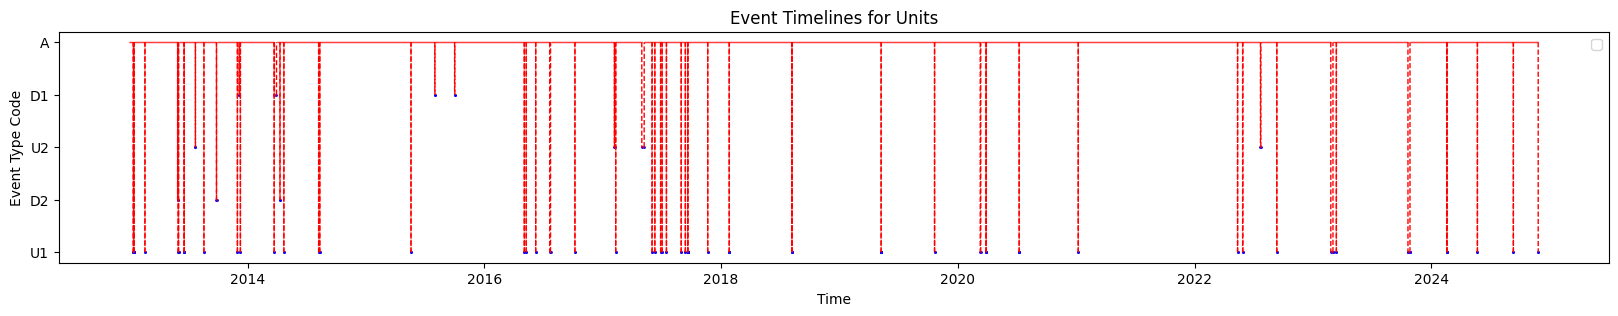

In [37]:
# check that the state transitions match the events

fig, ax = plt.subplots(figsize=(20, 3))
# for unit_id, events_unit in tqdm(events_subset_df.groupby('UnitID')):
for _, event in events_subset_df.iterrows():
    start = event['EventStartDT']
    end = event['EventEndDT']
    state = event['EventTypeCode']
    ax.plot([start, end], [state, state], color='blue', linewidth=1, marker='o', markersize=1)
for _, state_transition in state_transitions_data.iterrows():
    time = state_transition['Datetime']
    initial_state = state_transition['Initial_state']
    final_state = state_transition['Final_state']
    # if initial_state != final_state:
    ax.plot([time, time + pd.Timedelta(hours=1)], [initial_state, final_state], color='red', linestyle='--', linewidth=1)
ax.set_xlabel('Time')
ax.set_ylabel('Event Type Code')
ax.set_title('Event Timelines for Units')
ax.legend()
plt.show()

In [43]:
# Check continuity, i.e that the final state of one hour matches the initial state of the next hour for each unit
for unit_id, state_transitions_unit in state_transitions_data.groupby('UnitID'):
    state_transitions_unit = state_transitions_unit.sort_values('Datetime')
    for i in range(1, len(state_transitions_unit)):
        prev_final_state = state_transitions_unit.iloc[i-1]['Final_state']
        curr_initial_state = state_transitions_unit.iloc[i]['Initial_state']
        if prev_final_state != curr_initial_state:
            print(f"Discontinuity found for UnitID {unit_id} at {state_transitions_unit.iloc[i]['Datetime']}: {prev_final_state} != {curr_initial_state}")

In [9]:
# Compute transition probabilities
transition_counts = state_transitions_data.groupby(['Initial_state', 'Final_state']).size().unstack(fill_value=0)
transition_probabilities = transition_counts.div(transition_counts.sum(axis=1), axis=0)
transition_probabilities

Final_state,A,D,SF,U
Initial_state,,,,
A,0.998456,0.000820,0.000085,0.000638
D,0.012464,0.986853,0.000007,0.000676
SF,0.048657,0.000908,0.945155,0.005280
U,0.013759,0.000679,0.000153,0.985409


In [10]:
# Compute number of transitions
transition_counts = state_transitions_data.groupby(['Initial_state', 'Final_state']).size().unstack(fill_value=0)
# transition_probabilities = transition_counts.div(transition_counts.sum(axis=1), axis=0)
transition_counts

Final_state,A,D,SF,U
Initial_state,,,,
A,77825026,63918,6648,49751
D,62749,4968088,37,3402
SF,6377,119,123872,692
U,50191,2477,559,3594758


## Analysis

### Unit type

In [204]:
filtered_events_df['UnitTypeCodeName'].value_counts()

UnitTypeCodeName
Fossil-Steam                                       383649
Gas Turbine/Jet Engine (Simple Cycle Operation)    129550
Pumped Storage/Hydro                                92349
CC GT units                                         65448
CC steam units                                      52145
Combined Cycle Block                                46659
Miscellaneous                                       13240
Fluidized Bed                                       12910
Nuclear                                              9437
Multi-boiler/Multi-turbine                           7091
CoG GT units                                         6726
Geothermal                                           5169
Co-generator Block                                   4061
CoG steam units                                      3388
Internal Combustion/Reciprocating Engines            2528
Gas Turbine/Jet Engine with HSRG                      216
Name: count, dtype: int64

In [ ]:
#CC is combined cycle, CT is simple cycle, DS is diesel, HD is hydroelectric and pumped storage, NU is nuclear, ST is steam turbine

{"CC": "Combined Cycle", "CT": "Simple Cycle", "DS": "Diesel", "HD": "Hydroelectric", "NU": "Nuclear", "ST": "Steam Turbine"}

{'CC':["CC GT units",  "Combined Cycle Block", "Gas Turbine/Jet Engine with HSRG", "Co-generator Block"],
 'CT':["Gas Turbine/Jet Engine (Simple Cycle Operation)", "CoG GT units"],
 'DS':["Fluidized Bed", "Internal Combustion/Reciprocating Engines"],
 'HD':["Pumped Storage/Hydro"],
 'NU':["Nuclear"],
 'ST':["Fossil-Steam", "CoG steam units"]
}
#? Geothermal, "CC steam units", "Multi-boiler/Multi-turbine",

### Fuel type

In [56]:
filtered_events_df['FuelFailure'].value_counts()

FuelFailure
Gas                      171371
Water                     45685
Coal                      42897
Waste Heat                17387
Distillate Oil             8732
Wood                       1917
Lignite                    1897
Geothermal                 1878
Oil                        1817
Kerosene                   1759
Biomass                    1643
Other - Gas (Cu. Ft.)      1491
Other - Solid (Tons)       1341
Nuclear                    1048
Distillate Oil #2           606
Oil (like #6)               121
Petrolium Coke              101
Other Gas (Cu Ft)            73
Other - Liquid (BBL)         56
JP4 or JP5                   35
Sub-Bituminous Coal          15
Petroleum Coke               11
Name: count, dtype: int64

### Fuel use by each technology

In [57]:
for unit_type in filtered_events_df['UnitTypeCodeName'].unique():
    print(f"Unit type: {unit_type}")
    df_unit = filtered_events_df[filtered_events_df['UnitTypeCodeName'] == unit_type]
    print(df_unit['FuelFailure'].value_counts())
    print("\n")

Unit type: Geothermal
FuelFailure
Geothermal    1878
Name: count, dtype: int64


Unit type: Combined Cycle Block
FuelFailure
Gas                      15916
Waste Heat                 847
Other - Gas (Cu. Ft.)      287
Distillate Oil              36
Lignite                      8
Distillate Oil #2            5
Kerosene                     4
Oil                          2
Coal                         1
Name: count, dtype: int64


Unit type: Fossil-Steam
FuelFailure
Coal                     41701
Gas                      13704
Oil                       1661
Lignite                   1657
Wood                      1318
Biomass                   1010
Waste Heat                 877
Distillate Oil             488
Other - Solid (Tons)       410
Other - Gas (Cu. Ft.)      281
Oil (like #6)              120
Other Gas (Cu Ft)           38
Sub-Bituminous Coal         15
Distillate Oil #2           13
Other - Liquid (BBL)         2
Name: count, dtype: int64


Unit type: Nuclear
FuelFailure
Nuclear 

### Outage vs derate

In [58]:
filtered_events_df['EventTypeCode'].value_counts()

EventTypeCode
U1    283178
U2     12202
U3      6661
Name: count, dtype: int64

# Power demand

## 1. load the data

## 2. Analysis

# Joint analysis

### Data coverage

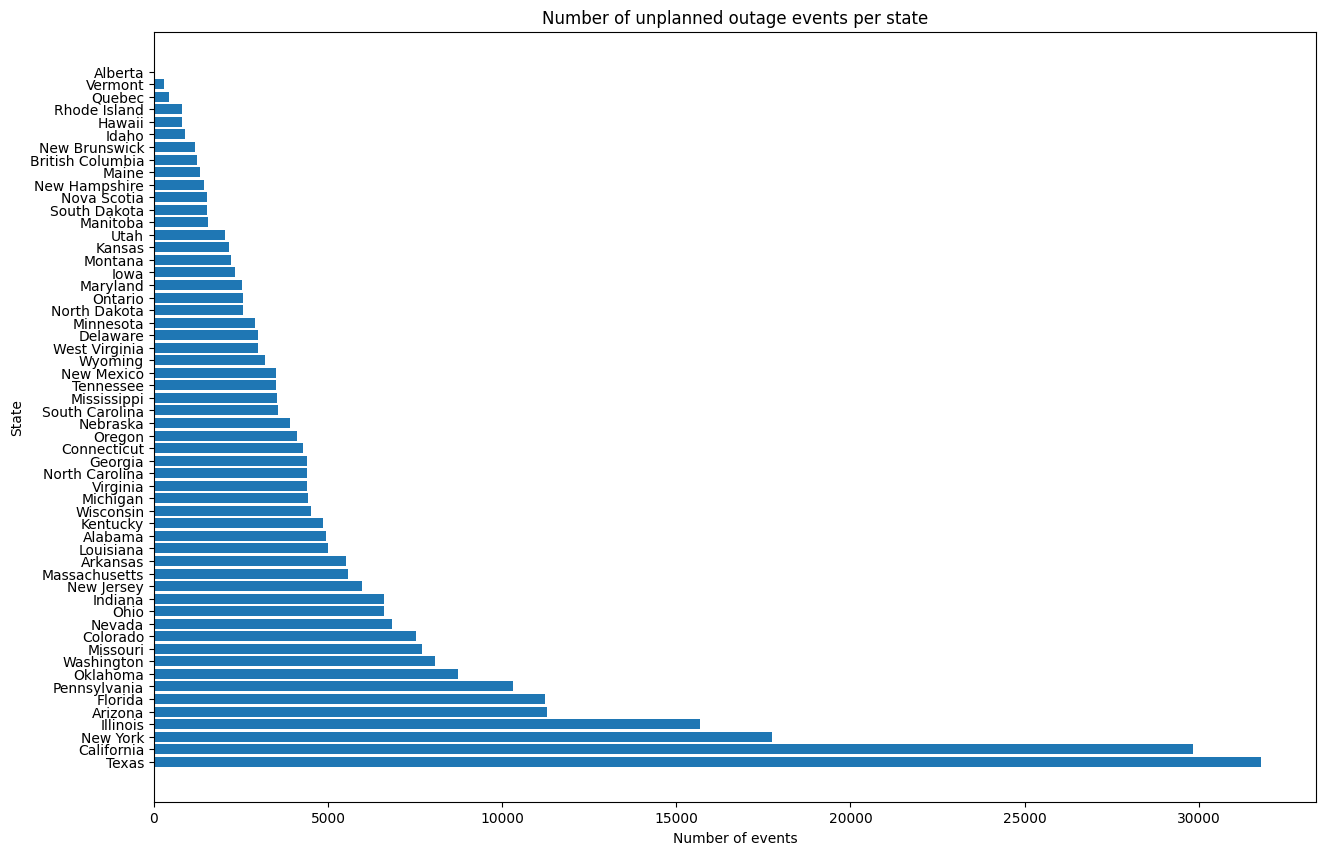

In [10]:
events_per_state = filtered_events_df['State'].value_counts()

plt.figure(figsize=(15,10))
plt.barh(events_per_state.index, events_per_state.values)
plt.xlabel("Number of events")
plt.ylabel("State")
plt.title("Number of unplanned outage events per state")
plt.show()

# Performances

In [116]:
performances_df = dp.load_performances()

Loading Performances : 2013
Loading Performances : 2014
Loading Performances : 2015
Loading Performances : 2016
Loading Performances : 2017
Loading Performances : 2018
Loading Performances : 2019
Loading Performances : 2020
Loading Performances : 2021
Loading Performances : 2022
Loading Performances : 2023
Loading Performances : 2024
Loaded 1035652 events


In [117]:
fuel_gathering = {
    "Gas" : ["Propane",  "Other - Gas (Cu. Ft.)", "Other Gas (Cu Ft)", "Gas"],
    "Oil" : ["Distillate Oil #2", "Oil", "Oil (like #6)", "Distillate Oil", "Other - Liquid (BBL)", "JP4 or JP5", "Kerosene"],
    "Coal" : ["Petroleum Coke", "Petrolium Coke", "Peat", "Bituminous Coal", "Sub-Bituminous Coal", "Coal", "Lignite", "Kerozene", "Other - Solid (Tons)"],
    "Nuclear" : ["Nuclear"],
    "Water" : ["Water"],
    "Bio source" : ["Sludge Gas", "Wood", "Biomass"],
    "Heat" : ["Waste Heat", "Geothermal"]
}

fuel_mapping = {}
for cat, fuels in fuel_gathering.items():
    for fuel in fuels:
        fuel_mapping[fuel] = cat

In [168]:
fuels = set(performances_df["FuelCodeName1"].unique()).union(set(performances_df["FuelCodeName2"].unique()))

In [119]:
for f in fuels:
    if f not in fuel_mapping:
        fuel_mapping[f] = "None"

In [120]:
performances_df['FuelCodeName1'] = performances_df['FuelCodeName1'].map(fuel_mapping)
performances_df['FuelCodeName2'] = performances_df['FuelCodeName2'].map(fuel_mapping)

In [160]:
main_fuels = defaultdict(lambda: defaultdict(int))
secondary_fuels = defaultdict(lambda: defaultdict(int))
for unit in tqdm(performances_df['UnitID'].unique()):
    perf_unit = performances_df[performances_df['UnitID'] == unit]
    technology = perf_unit['UnitTypeCodeName'].value_counts()
    if technology.size == 1:
        technology = perf_unit['UnitTypeCodeName'].iloc[0]
    else:
        technology = "Mixed"
        print(f"Multiple technologies for unit {unit}: {perf_unit['UnitTypeCodeName'].nunique()}")
    
    for _, row in perf_unit.iterrows():
        main_fuel = row['FuelCodeName1'] if row["FuelSequenceName1"]=="Primary Fuel" else row['FuelCodeName2'] if row["FuelSequenceName2"]=="Primary Fuel" else None
        secondary_fuel = row['FuelCodeName1'] if row["FuelSequenceName1"]=="Secondary Fuel" else row['FuelCodeName2'] if row["FuelSequenceName2"]=="Secondary Fuel" else None
        if main_fuel is not None:
            main_fuels[technology][main_fuel] +=1
        if secondary_fuel is not None:
            secondary_fuels[technology][secondary_fuel] +=1

100%|██████████| 9305/9305 [00:15<00:00, 592.98it/s] 


In [161]:
fuels = set(performances_df["FuelCodeName1"].unique()).union(set(performances_df["FuelCodeName2"].unique()))

In [162]:
for tech in main_fuels.keys():
    for fuel in fuels:
        if fuel not in main_fuels[tech]:
            main_fuels[tech][fuel] = 0
for tech in secondary_fuels.keys():
    for fuel in fuels:
        if fuel not in secondary_fuels[tech]:
            secondary_fuels[tech][fuel] = 0

In [163]:
technologies = set(main_fuels.keys()).union(set(secondary_fuels.keys()))

In [164]:
for tecch in technologies:
    if tech not in main_fuels:
        for fuel in fuels:
            main_fuels[tech][fuel] = 0
for tech in technologies:
    if tech not in secondary_fuels:
        for fuel in fuels:
            secondary_fuels[tech][fuel] = 0

In [165]:
main_fuels = pd.DataFrame(main_fuels).transpose()
secondary_fuels = pd.DataFrame(secondary_fuels).transpose()

In [172]:
main_fuels = main_fuels / (main_fuels.sum(axis=1).to_numpy().reshape(-1,1)) * 100
secondary_fuels = secondary_fuels / (secondary_fuels.sum(axis=1).to_numpy().reshape(-1,1)) * 100

In [177]:
fuels = list(fuels)

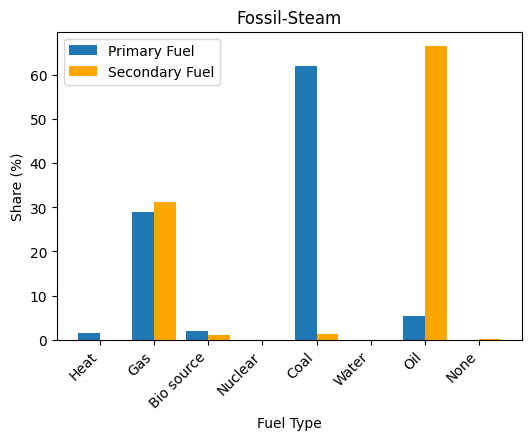

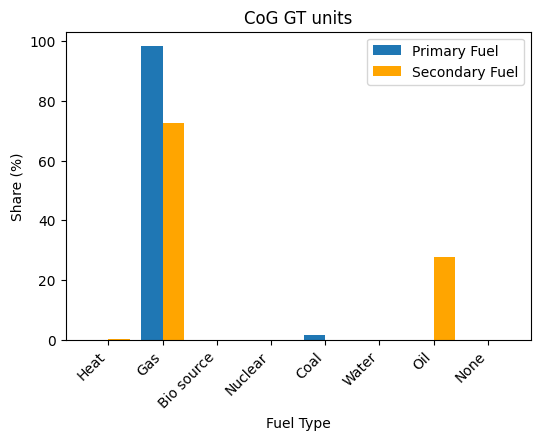

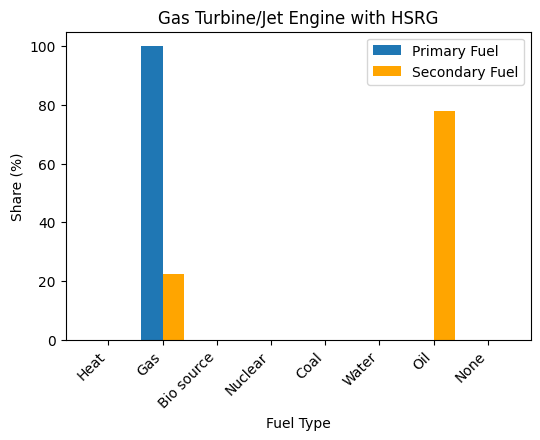

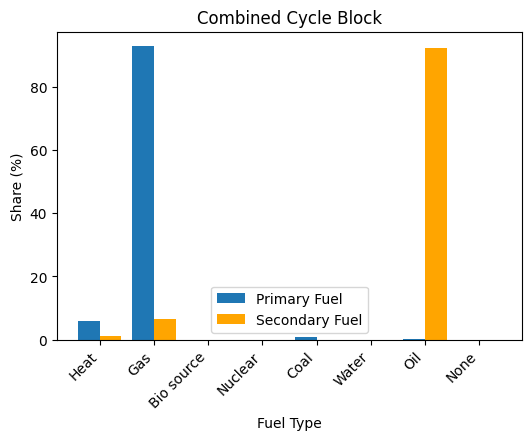

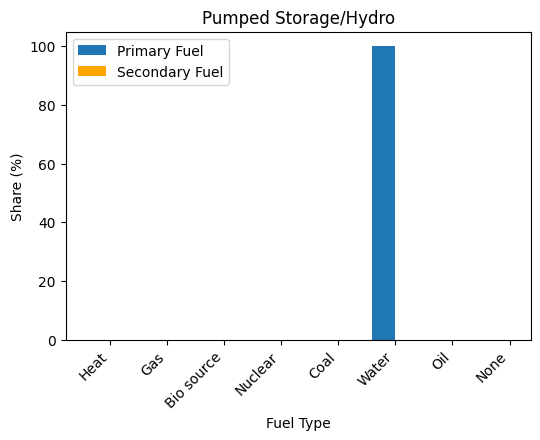

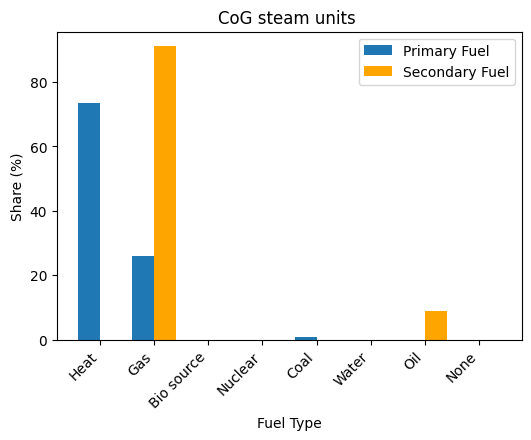

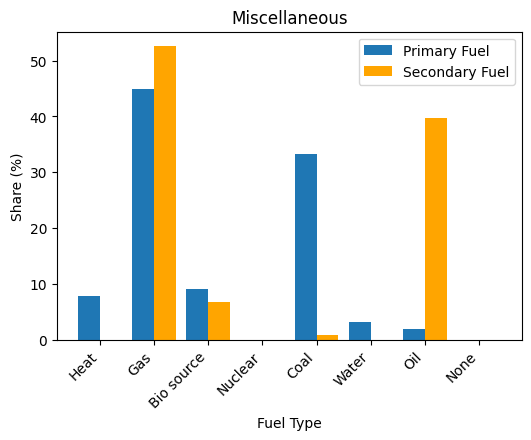

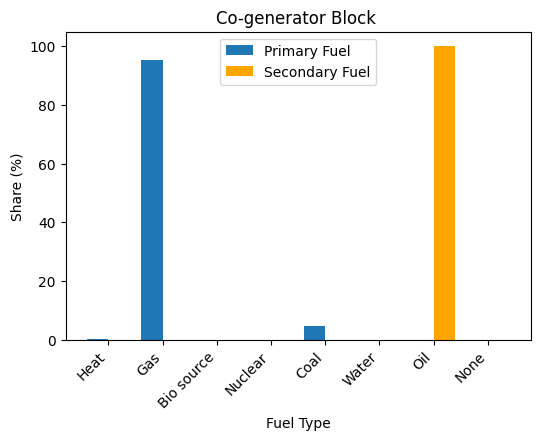

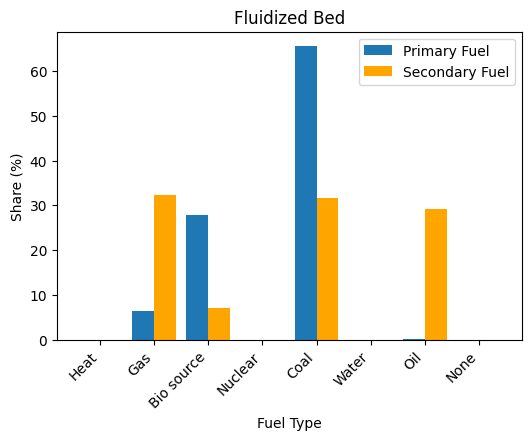

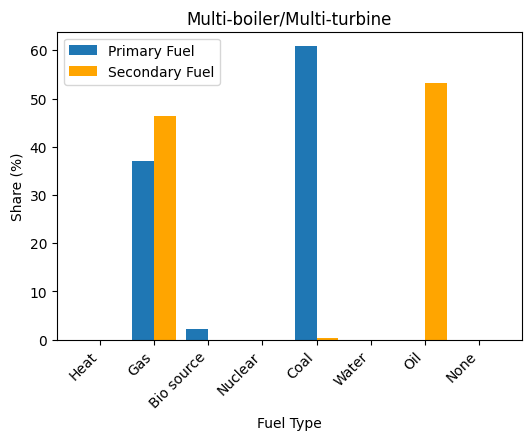

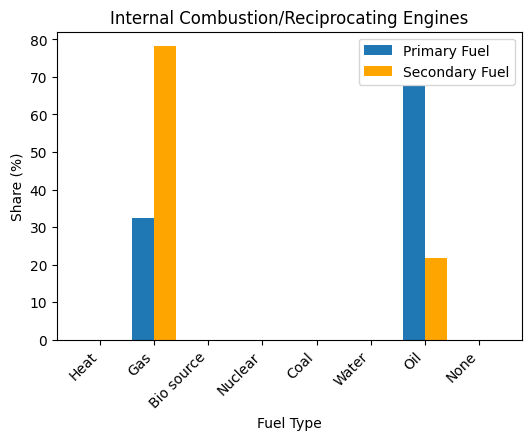

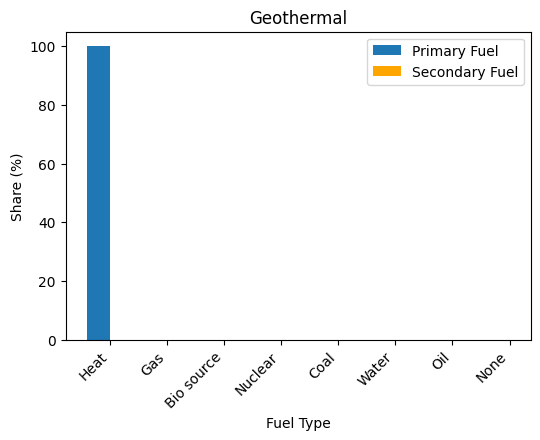

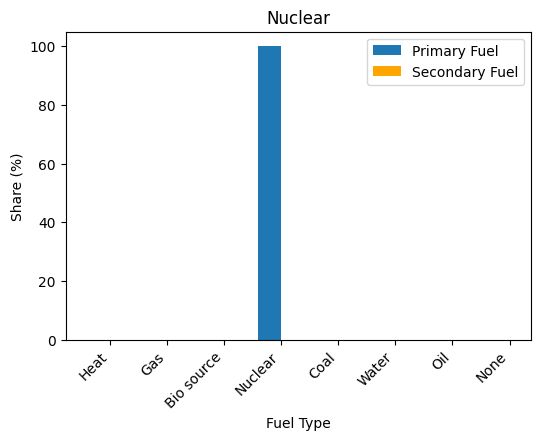

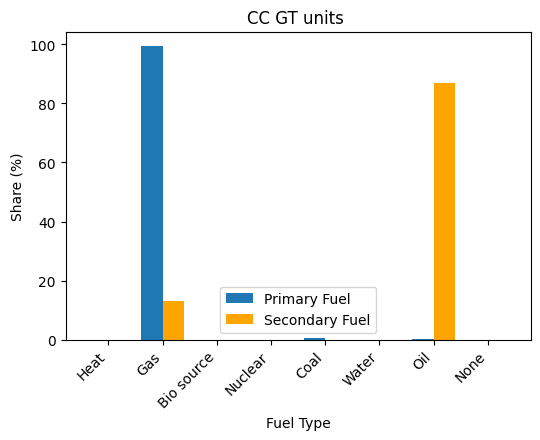

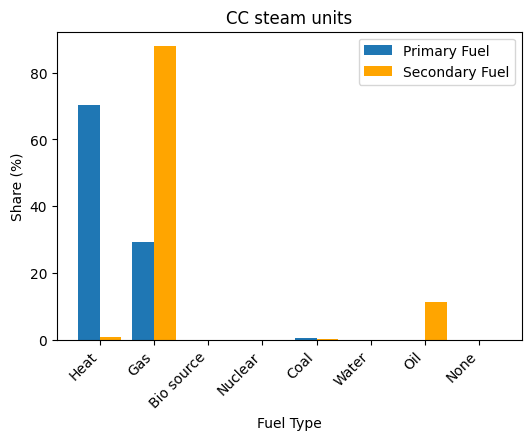

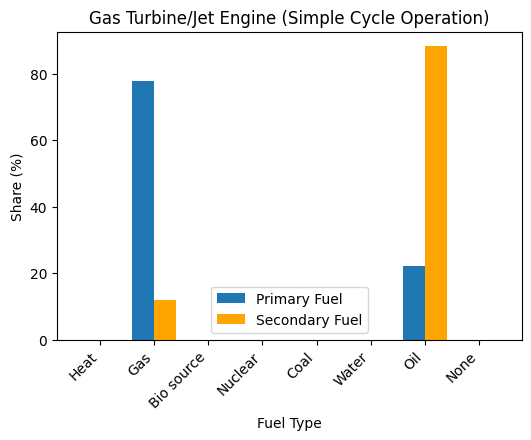

In [178]:
for tech in technologies:
    fig, ax = plt.subplots(figsize=(6,4))
    mf = main_fuels.loc[tech]#.plot(kind='bar', ax=ax, position=0, width=0.4, label='Primary Fuel')
    sf = secondary_fuels.loc[tech]#.plot(kind='bar', ax=ax, position=1, width=0.4, label='Secondary Fuel', color='orange')

    ax.bar(np.arange(len(fuels))-0.2, mf[fuels], width=0.4, label='Primary Fuel')
    ax.bar(np.arange(len(fuels))+0.2, sf[fuels], width=0.4, label='Secondary Fuel', color='orange')
    ax.set_xticks(np.arange(len(fuels)))
    ax.set_xticklabels(fuels, rotation=45, ha='right')
    ax.set_title(tech)
    ax.set_xlabel("Fuel Type")
    ax.set_ylabel("Share (%)")
    ax.legend()
    plt.show()

# Units classification

In [184]:
categories = {
    "Nuclear": ['Nuclear'],
    "Geothermal": ['Geothermal'],
    "Hydro": ['Pumped Storage/Hydro'],
    "Fuel-fired thermal" : ['Combined Cycle Block', 'Fossil-Steam', 'CC GT units ', 'Fluidized Bed','CC steam units','Gas Turbine/Jet Engine (Simple Cycle Operation)','Internal Combustion/Reciprocating Engines', 'Co-generator Block ', 'CoG GT units','Multi-boiler/Multi-turbine', 'CoG steam units ','Gas Turbine/Jet Engine with HSRG']
}

In [203]:
for cat, techs in categories.items():
    print(f"Category: {cat}")
    for tech in techs:
        n_units = performances_df[performances_df['UnitTypeCodeName'] == tech]['UnitID'].nunique()
        n_events = filtered_events_df[filtered_events_df['UnitTypeCodeName'] == tech].shape[0]
        print(f"    - {tech}, Number of units: {n_units}, Number of events: {n_events}")

Category: Nuclear
    - Nuclear, Number of units: 109, Number of events: 9437
Category: Geothermal
    - Geothermal, Number of units: 63, Number of events: 5169
Category: Hydro
    - Pumped Storage/Hydro, Number of units: 2816, Number of events: 92349
Category: Fuel-fired thermal
    - Combined Cycle Block, Number of units: 393, Number of events: 46659
    - Fossil-Steam, Number of units: 1471, Number of events: 383649
    - CC GT units , Number of units: 769, Number of events: 65448
    - Fluidized Bed, Number of units: 51, Number of events: 12910
    - CC steam units, Number of units: 387, Number of events: 52145
    - Gas Turbine/Jet Engine (Simple Cycle Operation), Number of units: 2561, Number of events: 129550
    - Internal Combustion/Reciprocating Engines, Number of units: 301, Number of events: 2528
    - Co-generator Block , Number of units: 49, Number of events: 4061
    - CoG GT units, Number of units: 130, Number of events: 6726
    - Multi-boiler/Multi-turbine, Number of 